
# 📘 Tesis – Temperaturas extremas y mortalidad cardiovascular  


## 1) Setup

In [1]:

# !pip install statsmodels patsy scipy --quiet
import re, unicodedata, warnings, traceback, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import patsy as pt
import statsmodels.api as sm
import scipy.stats as st

plt.rcParams["figure.dpi"] = 150
FIG_DPI = 300
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)

DATA_TEMP = Path("/content/temperaturas.csv")
DATA_HUM  = Path("/content/humedad_relativa.csv")
DATA_MORT = Path("/content/Mortalidad.csv")


## 2) Utilidades: lectura y normalización

In [2]:

def read_scsv(path):
    return pd.read_csv(path, sep=";", decimal=",", engine="python")

def strip_accents(s: str) -> str:
    s = str(s)
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def norm_colname(c: str) -> str:
    c2 = strip_accents(c).lower().strip()
    c2 = re.sub(r"\s+", " ", c2)
    c2 = c2.replace("(", "").replace(")", "").replace(".", "").replace(",", "")
    c2 = c2.replace("-", " ").replace("/", " ")
    c2 = re.sub(r"\s+", "_", c2)
    return c2

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [norm_colname(c) for c in df.columns]
    return df

def first_present(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def ensure_ciudad(df: pd.DataFrame, prefer_city=True) -> pd.DataFrame:
    df = df.copy()
    if "ciudad" in df.columns:
        return df
    col_city = first_present(df, ["city", "ciudad"])
    col_mun  = first_present(df, ["municipio"])
    if prefer_city and col_city is not None:
        df.rename(columns={col_city: "ciudad"}, inplace=True)
        return df
    if col_city is None and col_mun is not None:
        def from_mun(x):
            s = str(x)
            if " - " in s:
                return s.split(" - ", 1)[1].strip()
            return s.strip()
        df["ciudad"] = df[col_mun].map(from_mun)
        return df
    if col_city is not None:
        df.rename(columns={col_city: "ciudad"}, inplace=True)
        return df
    raise KeyError("No encontré columna para ciudad (city/ciudad/municipio).")

def std_city_name(x: str) -> str:
    s = strip_accents(str(x)).lower().strip()
    if "bogota" in s: return "Bogotá"
    if "medell" in s: return "Medellín"
    if "cali" in s: return "Cali"
    if "barranq" in s: return "Barranquilla"
    if s.startswith("bogota"): return "Bogotá"
    return str(x).strip()


## 3) Carga de datos y armonización

In [4]:
t = normalize_columns(read_scsv(DATA_TEMP))
h = normalize_columns(read_scsv(DATA_HUM))
m = normalize_columns(read_scsv(DATA_MORT))

for df in (t, h, m):
    col_y = first_present(df, ["ano","anio","year","year_date","yeardate","yearfecha"])
    if col_y and col_y != "anio":
        df.rename(columns={col_y:"anio"}, inplace=True)
    col_w = first_present(df, ["semana","week","wk"])
    if col_w and col_w != "semana":
        df.rename(columns={col_w:"semana"}, inplace=True)

if "tmax" not in t.columns:
    cand = first_present(t, ["t_max","temp_max","tmax"])
    if cand: t.rename(columns={cand:"tmax"}, inplace=True)
if "tmin" not in t.columns:
    cand = first_present(t, ["t_min","temp_min","tmin"])
    if cand: t.rename(columns={cand:"tmin"}, inplace=True)
if "tmean" not in t.columns:
    cand = first_present(t, ["t_mean","temp_mean","tmean"])
    if cand: t.rename(columns={cand:"tmean"}, inplace=True)

if "humedad" not in h.columns:
    cand = first_present(h, ["rh","humedad_relativa","humedad","rel_humidity","relative_humidity"])
    if cand: h.rename(columns={cand:"humedad"}, inplace=True)

if "muertes" not in m.columns:
    cand = first_present(m, ["mortalidad","defunciones","muertes_ecv","muertes"])
    if cand: m.rename(columns={cand:"muertes"}, inplace=True)

t = ensure_ciudad(t, prefer_city=True)
h = ensure_ciudad(h, prefer_city=True)
if "municipio" in m.columns and "ciudad" not in m.columns:
    m = ensure_ciudad(m, prefer_city=False)
else:
    m = ensure_ciudad(m, prefer_city=True)

t["ciudad"] = t["ciudad"].map(std_city_name)
h["ciudad"] = h["ciudad"].map(std_city_name)
m["ciudad"] = m["ciudad"].map(std_city_name)

for df in (t, h, m):
    if "anio" not in df.columns or "semana" not in df.columns:
        raise KeyError("Faltan 'anio' o 'semana' tras la normalización.")
    df["anio"] = pd.to_numeric(df["anio"], errors="coerce").astype("Int64")
    df["semana"] = pd.to_numeric(df["semana"], errors="coerce").astype("Int64")

t = t[[c for c in ["anio","semana","ciudad","tmax","tmin","tmean"] if c in t.columns]].copy()
h = h[[c for c in ["anio","semana","ciudad","humedad"] if c in h.columns]].copy()
m = m[[c for c in ["anio","semana","ciudad","muertes"] if c in m.columns]].copy()

# Merge
for name, df in [("t", t), ("h", h), ("m", m)]:
    for must in ["anio","semana","ciudad"]:
        if must not in df.columns:
            raise KeyError(f"En {name} falta la columna requerida: '{must}'")

dfw = pd.merge(t, h, on=["anio","semana","ciudad"], how="left")
dfw = pd.merge(dfw, m, on=["anio","semana","ciudad"], how="left")

# fecha
def week_monday(year, week):
    w = int(max(1, min(53, int(week))))
    return pd.to_datetime(f"{int(year)}-W{w:02d}-1", format="%G-W%V-%u", errors="coerce")

dfw["fecha"] = [week_monday(y, w) for y, w in zip(dfw["anio"], dfw["semana"])]
dfw = dfw.sort_values(["ciudad","fecha"]).reset_index(drop=True)

# Imputación humedad
if "humedad" in dfw.columns:
    dfw["humedad"] = dfw.groupby("ciudad")["humedad"].transform(lambda s: s.fillna(s.median()))

dfw.head()

,anio,semana,ciudad,tmax,tmin,tmean,humedad,muertes,fecha
0,2010,1,Barranquilla,30.754286,24.925714,27.840000,77.977143,13,2010-01-04
1,2010,2,Barranquilla,30.408571,25.112857,27.760714,75.570000,19,2010-01-11
2,2010,3,Barranquilla,31.718571,24.762857,28.240714,75.620000,10,2010-01-18
3,2010,4,Barranquilla,31.382857,25.655714,28.519286,82.158571,14,2010-01-25
4,2010,5,Barranquilla,31.462857,25.050000,28.256429,74.971429,17,2010-02-01


## 4) Modelado ultra-robusto (con fallback)

In [5]:

def available_temp_vars(df: pd.DataFrame):
    present = [v for v in ["tmax","tmin","tmean"] if v in df.columns]
    present = [v for v in present if df[v].notna().any()]
    return present

def _formula_from_list(tv):
    if ("tmax" in tv) and ("tmin" in tv):
        return "cr(tmax, df=4) + cr(tmin, df=4)", ["tmax","tmin"]
    if "tmax" in tv:
        return "cr(tmax, df=4)", ["tmax"]
    if "tmin" in tv:
        return "cr(tmin, df=4)", ["tmin"]
    if "tmean" in tv:
        return "cr(tmean, df=4)", ["tmean"]
    return None, []

def build_formula_for_df(df: pd.DataFrame):
    tv = available_temp_vars(df)
    temp_part, rr_vars = _formula_from_list(tv)
    if temp_part is None:
        return None, []
    controls = "cr(t_ordinal, df=7) + year_sin + year_cos"
    if ("humedad" in df.columns) and (not df["humedad"].isna().all()):
        controls += " + humedad"
    return f"muertes ~ {temp_part} + {controls}", rr_vars

def _safe_fit(formula, d2, rr_vars):
    try:
        y, X = pt.dmatrices(formula, d2, return_type="dataframe")
        model = sm.GLM(y, X, family=sm.families.Poisson())
        res = model.fit()
        return res, X, rr_vars
    except Exception as e:
        tv2 = available_temp_vars(d2)
        temp_part2, rr2 = _formula_from_list(tv2)
        if temp_part2 is None:
            raise e
        controls = "cr(t_ordinal, df=7) + year_sin + year_cos"
        if ("humedad" in d2.columns) and (not d2["humedad"].isna().all()):
            controls += " + humedad"
        formula2 = f"muertes ~ {temp_part2} + {controls}"
        y, X = pt.dmatrices(formula2, d2, return_type="dataframe")
        model = sm.GLM(y, X, family=sm.families.Poisson())
        res = model.fit()
        return res, X, rr2

def fit_city(df_city: pd.DataFrame, ciudad: str):
    d = df_city.copy()
    d["t_ordinal"] = (d["fecha"] - d["fecha"].min()).dt.days
    d["year_sin"]  = np.sin(2*np.pi*d["t_ordinal"]/365.25)
    d["year_cos"]  = np.cos(2*np.pi*d["t_ordinal"]/365.25)
    if "humedad" in d.columns:
        if d["humedad"].isna().all():
            d["humedad"] = d["humedad"].fillna(d["humedad"].median())
        else:
            d["humedad"] = d["humedad"].interpolate(limit_direction="both")

    formula, rr_vars = build_formula_for_df(d)
    if not formula:
        warnings.warn(f"[{ciudad}] Sin variables de temperatura utilizables. Se omite.")
        return None

    need_cols = ["muertes"] + rr_vars
    d2 = d.dropna(subset=[c for c in need_cols if c in d.columns])
    if len(d2) < 50:
        warnings.warn(f"[{ciudad}] Pocos registros válidos (n={len(d2)}). Se omite.")
        return None

    res, X, rr_used = _safe_fit(formula, d2, rr_vars)
    return {
        "ciudad": ciudad,
        "aic": res.aic,
        "deviance": res.deviance,
        "n": int(res.model.endog.shape[0]),
        "model": res,
        "design_info": X.design_info,
        "rr_vars": rr_used,
        "origin": d["fecha"].min(),
    }


## 5) Ajuste por ciudad

In [6]:

fits = {}
rows = []
for ciudad, g in dfw.groupby("ciudad"):
    fit = fit_city(g, ciudad)
    if fit is None:
        print(f"⚠️  {ciudad}: omitida (sin suficientes datos o sin variables de temperatura).")
        continue
    fits[ciudad] = fit
    rows.append({"ciudad": ciudad, "aic": fit["aic"], "deviance": fit["deviance"], "n": fit["n"], "vars": ",".join(fit["rr_vars"])})

stats_df = pd.DataFrame(rows).sort_values("ciudad")
display(stats_df)


,ciudad,aic,deviance,n,vars
0,Barranquilla,3486.929232,803.432906,530,"tmax,tmin"
1,Bogotá,5389.007233,1926.463467,530,"tmax,tmin"
2,Cali,4027.015662,1096.372240,530,"tmax,tmin"
3,Medellín,4365.487425,1281.624959,530,"tmax,tmin"


## 6) Curvas RR + MMT

In [7]:

def rr_curve(fit, df_city, var, npts=80):
    if var not in df_city.columns or not df_city[var].notna().any():
        return pd.DataFrame()
    d = df_city.dropna(subset=[var, "muertes"]).copy()
    origin = fit["origin"]
    d["t_ordinal"] = (d["fecha"] - origin).dt.days
    d["year_sin"]  = np.sin(2*np.pi*d["t_ordinal"]/365.25)
    d["year_cos"]  = np.cos(2*np.pi*d["t_ordinal"]/365.25)
    if "humedad" in d.columns:
        d["humedad"] = d["humedad"].fillna(d["humedad"].median())
    vals = np.linspace(d[var].quantile(0.01), d[var].quantile(0.99), npts)
    cols_needed = ["tmax","tmin","tmean","t_ordinal","year_sin","year_cos","humedad"]
    base = d.median(numeric_only=True)
    base_df = pd.DataFrame({c:[base.get(c, np.nan)] for c in cols_needed if c in d.columns})
    mu = []
    for v in vals:
        row = base_df.copy(); row[var] = v
        Xg = pt.build_design_matrices([fit["design_info"]], row)[0]
        mu.append(float(fit["model"].predict(Xg)[0]))
    out = pd.DataFrame({var: vals, "mu_pred": mu})
    out["RR"] = out["mu_pred"] / out["mu_pred"].min()
    out["MMT"] = out.loc[out["mu_pred"].idxmin(), var]
    return out

# Construcción y gráficos
rr_rows = []
for ciudad, g in dfw.groupby("ciudad"):
    if ciudad not in fits: continue
    fit = fits[ciudad]
    for var in fit["rr_vars"]:
        cur = rr_curve(fit, g, var)
        if cur.empty: continue
        cur["ciudad"] = ciudad; cur["variable"] = var
        rr_rows.append(cur)

rr_df = pd.concat(rr_rows, ignore_index=True) if rr_rows else pd.DataFrame()
display(rr_df.head())


,tmax,mu_pred,RR,MMT,ciudad,variable,tmin
0,28.146200,23.652528,1.000000,28.1462,Barranquilla,tmax,NaN
1,28.199922,23.812659,1.006770,28.1462,Barranquilla,tmax,NaN
2,28.253643,23.971850,1.013501,28.1462,Barranquilla,tmax,NaN
3,28.307365,24.129914,1.020183,28.1462,Barranquilla,tmax,NaN
4,28.361086,24.286663,1.026810,28.1462,Barranquilla,tmax,NaN


## 7) Escenarios

In [8]:

def predict_sum(fit, d):
    Xp = pt.build_design_matrices([fit["design_info"]], d)[0]
    return float(fit["model"].predict(Xp).sum())

esc_rows = []
for ciudad, g in dfw.groupby("ciudad"):
    if ciudad not in fits: continue
    fit = fits[ciudad]
    d = g.dropna(subset=["muertes"]).copy()
    if len(d) < 50: continue
    origin = fit["origin"]
    d["t_ordinal"] = (d["fecha"] - origin).dt.days
    d["year_sin"]  = np.sin(2*np.pi*d["t_ordinal"]/365.25)
    d["year_cos"]  = np.cos(2*np.pi*d["t_ordinal"]/365.25)
    if "humedad" in d.columns:
        d["humedad"] = d["humedad"].fillna(d["humedad"].median())
    used_vars = fit["rr_vars"]
    if not any([(v in d.columns and d[v].notna().any()) for v in used_vars]):
        print(f"⚠️  {ciudad}: sin variables de temperatura utilizables para escenarios.")
        continue
    def add_delta(temp_df, delta, vars_used):
        dd = temp_df.copy()
        for v in vars_used:
            if v in dd.columns:
                dd[v] = dd[v] + delta
        return dd
    base_mu = predict_sum(fit, d)
    s1 = add_delta(d, 1.0, used_vars)
    s2 = add_delta(d, 2.0, used_vars)
    s3 = d.copy()
    if "tmax" in used_vars and "tmax" in s3.columns and s3["tmax"].notna().any():
        p95_max = s3["tmax"].quantile(0.95); s3["tmax"] = np.minimum(s3["tmax"], p95_max)
    if "tmin" in used_vars and "tmin" in s3.columns and s3["tmin"].notna().any():
        p05_min = s3["tmin"].quantile(0.05); s3["tmin"] = np.maximum(s3["tmin"], p05_min)
    if used_vars == ["tmean"] and "tmean" in s3.columns:
        p95_mean = s3["tmean"].quantile(0.95); p05_mean = s3["tmean"].quantile(0.05)
        s3["tmean"] = np.clip(s3["tmean"], p05_mean, p95_mean)
    for name, dd in [("Base", d), ("+1C", s1), ("+2C", s2), ("Extremos(p95/p05)", s3)]:
        esc_rows.append({"ciudad": ciudad, "escenario": name, "mu_previstas": predict_sum(fit, dd)})
esc = pd.DataFrame(esc_rows)
display(esc.head())


,ciudad,escenario,mu_previstas
0,Barranquilla,Base,13176.000000
1,Barranquilla,+1C,13386.918901
2,Barranquilla,+2C,14052.672361
3,Barranquilla,Extremos(p95/p05),13198.675818
4,Bogotá,Base,56151.000000


## 8) Evaluación predictiva (DIVIDIDA)

### 8.0 Diagnóstico de columnas y diseño

In [9]:

def design_required_columns(design_info):
    """Extrae nombres crudos que el diseño espera (tmax, tmin, tmean, humedad, t_ordinal, year_sin, year_cos)."""
    raw = set()
    for term in design_info.term_names:
        # Term names de splines se ven como 'cr(tmax, df=4)[0]' etc.
        if "cr(" in term:
            inside = term.split("cr(",1)[1].split(",",1)[0].strip()
            raw.add(inside)
        elif term in {"Intercept","1"}:
            continue
        else:
            raw.add(term)
    return sorted(raw)

def ensure_required_columns(df_in, required, fallback_source=None, warn_prefix=""):
    """Si falta alguna requerida (p.ej., tmax), la crea: usa tmean si existe o la mediana de la ciudad."""
    df = df_in.copy()
    for col in required:
        if col not in df.columns:
            if fallback_source is not None and fallback_source in df.columns:
                df[col] = df[fallback_source]
                print(f"{warn_prefix}⚠️ creando '{col}' a partir de '{fallback_source}'")
            else:
                med = np.nanmedian(df.select_dtypes(include=[np.number]).values) if df.select_dtypes(include=[np.number]).size else 0.0
                df[col] = med
                print(f"{warn_prefix}⚠️ creando '{col}' con mediana numérica global {med:.3f}")
    return df

# Simple inspección
for ciudad, g in dfw.groupby("ciudad"):
    if ciudad not in fits:
        print(f"— {ciudad}: sin modelo —");
        continue
    fit = fits[ciudad]
    req = design_required_columns(fit["design_info"])
    print(f"[{ciudad}] diseño requiere: {req}; rr_vars={fit['rr_vars']}")


[Barranquilla] diseño requiere: ['humedad', 't_ordinal', 'tmax', 'tmin', 'year_cos', 'year_sin']; rr_vars=['tmax', 'tmin']
[Bogotá] diseño requiere: ['humedad', 't_ordinal', 'tmax', 'tmin', 'year_cos', 'year_sin']; rr_vars=['tmax', 'tmin']
[Cali] diseño requiere: ['humedad', 't_ordinal', 'tmax', 'tmin', 'year_cos', 'year_sin']; rr_vars=['tmax', 'tmin']
[Medellín] diseño requiere: ['humedad', 't_ordinal', 'tmax', 'tmin', 'year_cos', 'year_sin']; rr_vars=['tmax', 'tmin']


### 8.1 Split temporal 80/20

In [10]:

split_data = {}
for ciudad, g in dfw.groupby("ciudad"):
    d = g.dropna(subset=["muertes"]).sort_values("fecha").copy()
    if len(d) < 60:
        continue
    split_idx = int(len(d)*0.8)
    split_data[ciudad] = {"train": d.iloc[:split_idx].copy(), "test": d.iloc[split_idx:].copy()}
print("Ciudades con split:", list(split_data.keys()))


Ciudades con split: ['Barranquilla', 'Bogotá', 'Cali', 'Medellín']


### 8.2 Entrenamiento seguro en TRAIN

In [11]:

def fit_city_on(df_city: pd.DataFrame):
    d = df_city.copy()
    d["t_ordinal"] = (d["fecha"] - d["fecha"].min()).dt.days
    d["year_sin"]  = np.sin(2*np.pi*d["t_ordinal"]/365.25)
    d["year_cos"]  = np.cos(2*np.pi*d["t_ordinal"]/365.25)
    if "humedad" in d.columns:
        if d["humedad"].isna().all():
            d["humedad"] = d["humedad"].fillna(d["humedad"].median())
        else:
            d["humedad"] = d["humedad"].interpolate(limit_direction="both")
    formula, rr_vars = build_formula_for_df(d)
    if not formula: return None
    need_cols = ["muertes"] + rr_vars
    d2 = d.dropna(subset=[c for c in need_cols if c in d.columns])
    if len(d2) < 30: return None
    res, X, rr_used = _safe_fit(formula, d2, rr_vars)
    return {"model": res, "design_info": X.design_info, "rr_vars": rr_used, "origin": d["fecha"].min()}

fits_tt = {}
for ciudad, sd in split_data.items():
    ft = fit_city_on(sd["train"])
    if ft is None:
        print(f"⚠️ {ciudad}: sin modelo en TRAIN")
        continue
    fits_tt[ciudad] = ft
    req = design_required_columns(ft["design_info"])
    print(f"[TRAIN {ciudad}] req={req}, rr_vars={ft['rr_vars']}")


[TRAIN Barranquilla] req=['humedad', 't_ordinal', 'tmax', 'tmin', 'year_cos', 'year_sin'], rr_vars=['tmax', 'tmin']
[TRAIN Bogotá] req=['humedad', 't_ordinal', 'tmax', 'tmin', 'year_cos', 'year_sin'], rr_vars=['tmax', 'tmin']
[TRAIN Cali] req=['humedad', 't_ordinal', 'tmax', 'tmin', 'year_cos', 'year_sin'], rr_vars=['tmax', 'tmin']
[TRAIN Medellín] req=['humedad', 't_ordinal', 'tmax', 'tmin', 'year_cos', 'year_sin'], rr_vars=['tmax', 'tmin']


### 8.3 Diseño para TRAIN/TEST (con column fallback)

In [12]:

def add_controls(df_, origin):
    dd = df_.copy()
    dd["t_ordinal"] = (dd["fecha"] - origin).dt.days
    dd["year_sin"]  = np.sin(2*np.pi*dd["t_ordinal"]/365.25)
    dd["year_cos"]  = np.cos(2*np.pi*dd["t_ordinal"]/365.25)
    if "humedad" in dd.columns:
        dd["humedad"] = dd["humedad"].fillna(dd["humedad"].median())
    return dd

design_mats = {}
for ciudad, sd in split_data.items():
    if ciudad not in fits_tt:
        continue
    ft = fits_tt[ciudad]
    origin = sd["train"]["fecha"].min()
    req = design_required_columns(ft["design_info"])
    # TRAIN
    train_p = add_controls(sd["train"], origin)
    # Column fallback (usa tmean si falta tmax/tmin)
    if "tmean" in train_p.columns:
        train_p = ensure_required_columns(train_p, req, fallback_source="tmean", warn_prefix=f"[TRAIN {ciudad}] ")
    else:
        train_p = ensure_required_columns(train_p, req, fallback_source=None, warn_prefix=f"[TRAIN {ciudad}] ")
    Xtr = pt.build_design_matrices([ft["design_info"]], train_p)[0]
    # TEST
    test_p  = add_controls(sd["test"], origin)
    if "tmean" in test_p.columns:
        test_p = ensure_required_columns(test_p, req, fallback_source="tmean", warn_prefix=f"[TEST {ciudad}] ")
    else:
        test_p = ensure_required_columns(test_p, req, fallback_source=None, warn_prefix=f"[TEST {ciudad}] ")
    Xte = pt.build_design_matrices([ft["design_info"]], test_p)[0]
    design_mats[ciudad] = {"Xtr": Xtr, "Xte": Xte, "train_p": train_p, "test_p": test_p}
    print(f"[OK diseño {ciudad}] Xtr={Xtr.shape}, Xte={Xte.shape}")


[OK diseño Barranquilla] Xtr=(424, 19), Xte=(106, 19)
[OK diseño Bogotá] Xtr=(424, 19), Xte=(106, 19)
[OK diseño Cali] Xtr=(424, 19), Xte=(106, 19)
[OK diseño Medellín] Xtr=(424, 19), Xte=(106, 19)


### 8.4 Predicción y métricas

In [13]:

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    eps = 1e-9
    with np.errstate(divide="ignore", invalid="ignore"):
        dev = 2.0 * np.nansum(y_true * np.log((y_true + eps)/(y_pred + eps)) - (y_true - y_pred))
    corr = np.corrcoef(y_true, y_pred)[0,1] if len(y_true)>1 else np.nan
    r2 = corr**2 if corr==corr else np.nan
    return {"MAE": mae, "RMSE": rmse, "PoissonDeviance": dev, "R2_Pearson": r2}

eval_rows = []
pred_store = {}
for ciudad, objs in design_mats.items():
    ft = fits_tt[ciudad]
    yhat_tr = ft["model"].predict(objs["Xtr"])
    yhat_te = ft["model"].predict(objs["Xte"])
    train = split_data[ciudad]["train"]
    test  = split_data[ciudad]["test"]
    m_tr = metrics(train["muertes"], yhat_tr)
    m_te = metrics(test["muertes"],  yhat_te)
    eval_rows.append({"ciudad": ciudad, "n_train": len(train), "n_test": len(test),
                      **{f"train_{k}": v for k,v in m_tr.items()},
                      **{f"test_{k}":  v for k,v in m_te.items()}})
    pred_store[ciudad] = {
        "train": pd.DataFrame({"fecha": train["fecha"].values, "obs": train["muertes"].values, "pred": yhat_tr}),
        "test":  pd.DataFrame({"fecha": test["fecha"].values,  "obs": test["muertes"].values,  "pred": yhat_te}),
        "fit": ft, "origin": split_data[ciudad]["train"]["fecha"].min(),
    }

eval_df = pd.DataFrame(eval_rows).sort_values("ciudad")
display(eval_df)


,ciudad,n_train,n_test,train_MAE,train_RMSE,train_PoissonDeviance,train_R2_Pearson,test_MAE,test_RMSE,test_PoissonDeviance,test_R2_Pearson
0,Barranquilla,424,106,4.299824,5.649764,628.004631,0.334328,5.234773,6.979195,196.053593,0.113005
1,Bogotá,424,106,11.712469,16.962203,1468.807801,0.188608,25.394805,30.767062,1042.816637,0.015002
2,Cali,424,106,6.304656,8.439772,867.151520,0.154350,11.934271,14.289403,636.686850,0.001136
3,Medellín,424,106,7.335019,10.151092,977.289582,0.348980,13.943576,17.383343,581.554296,0.041120


### 8.5 Gráficas

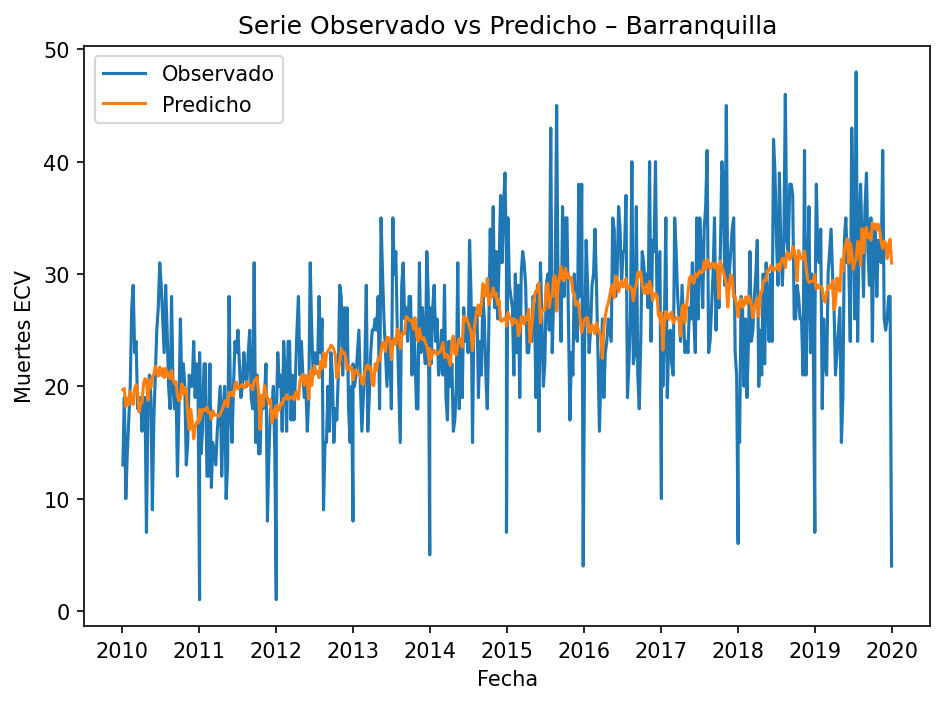

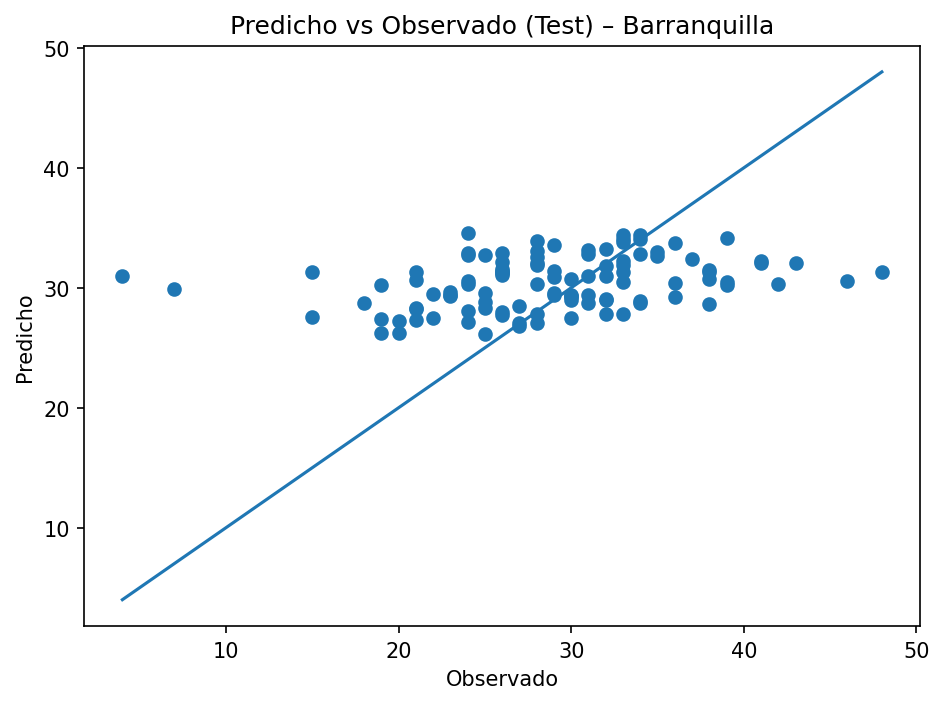

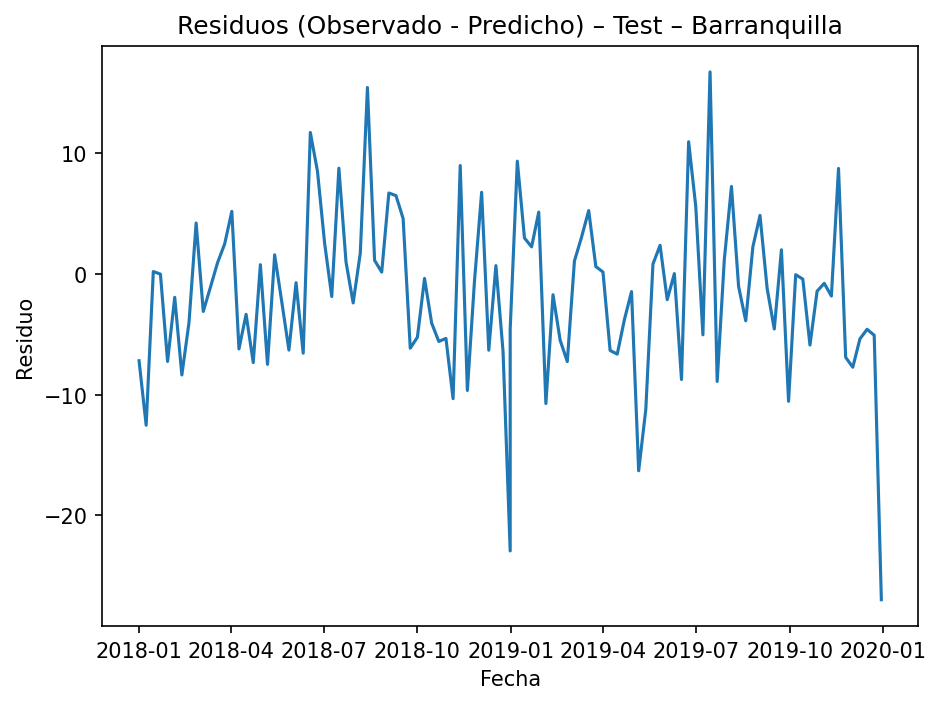

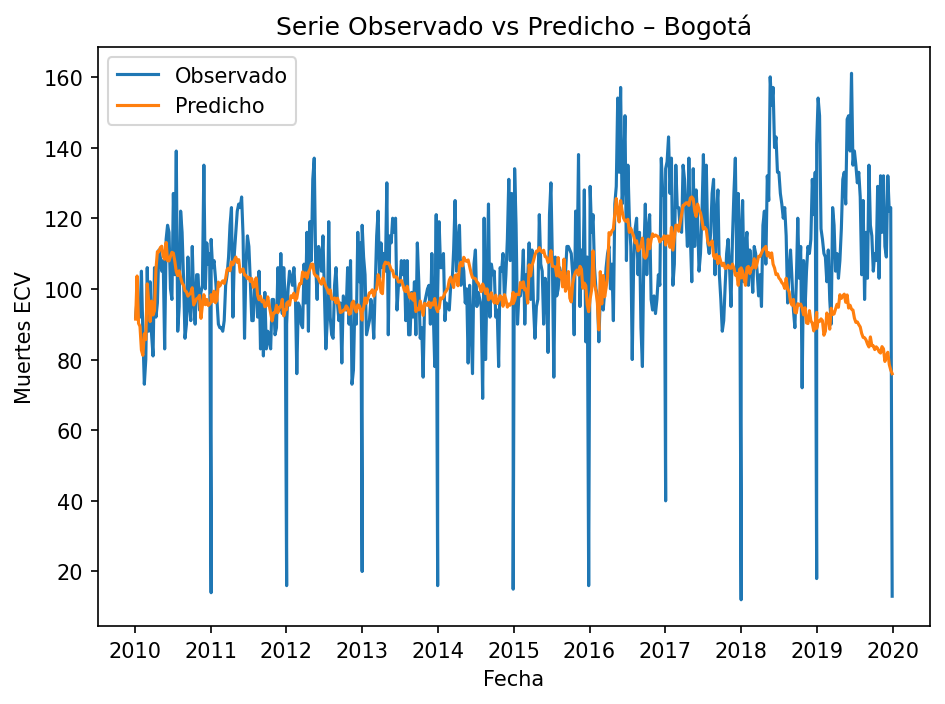

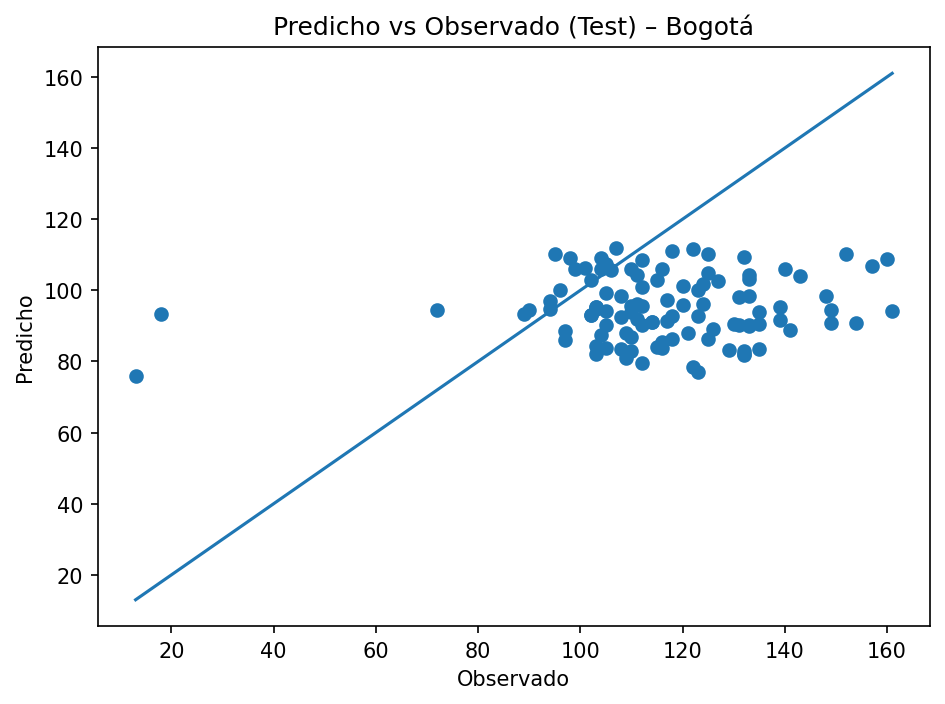

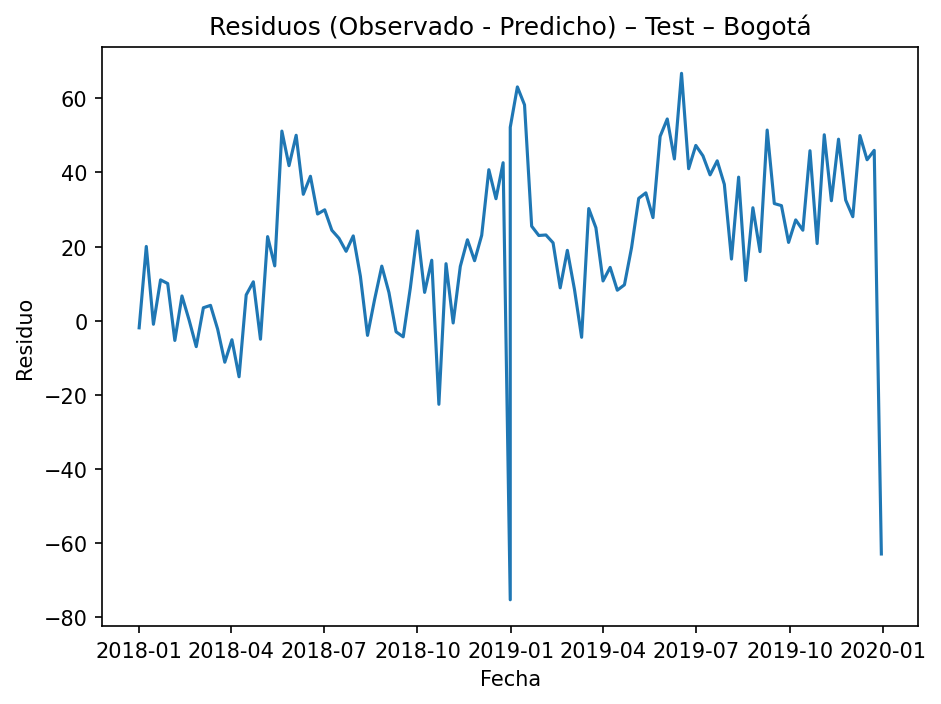

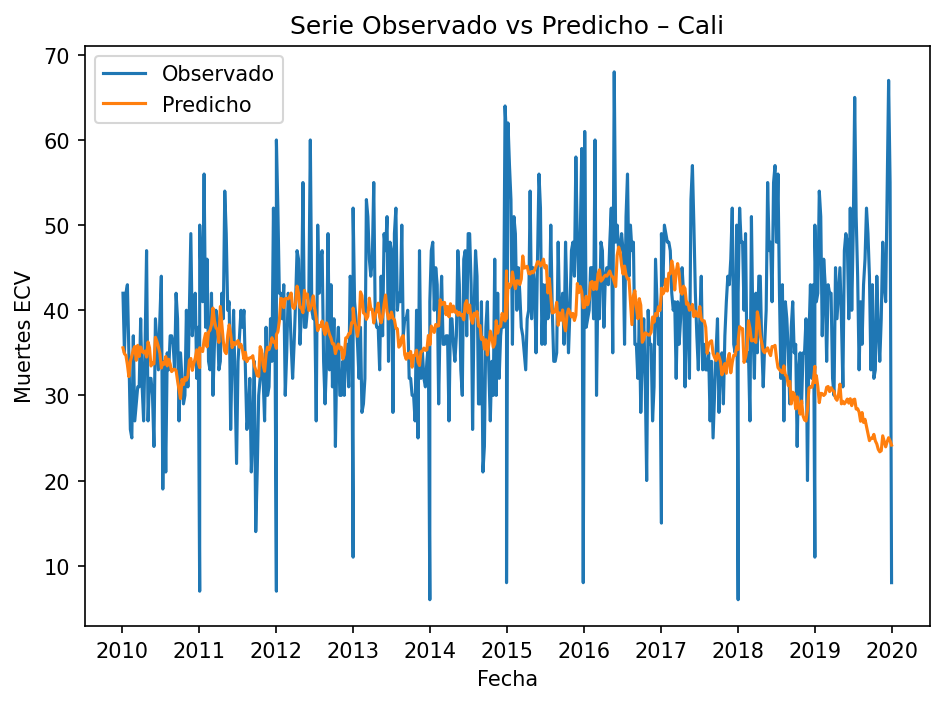

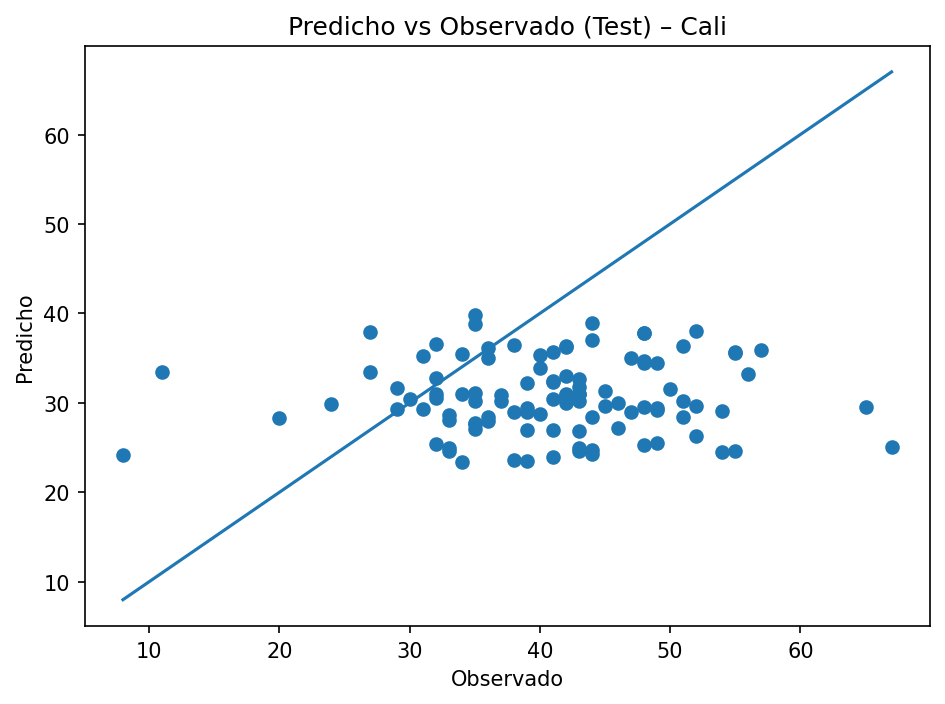

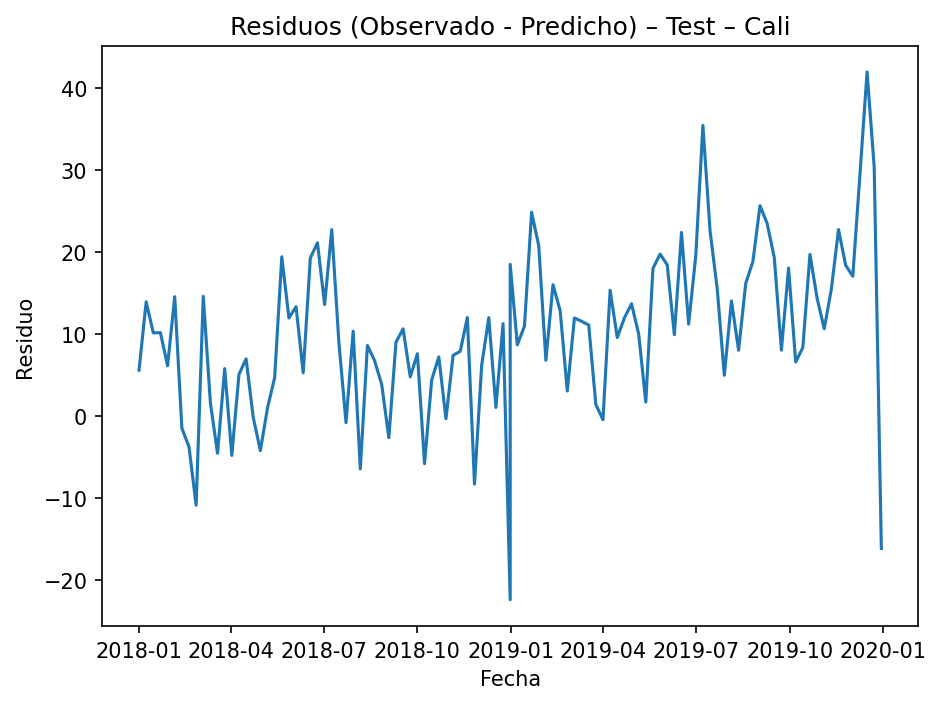

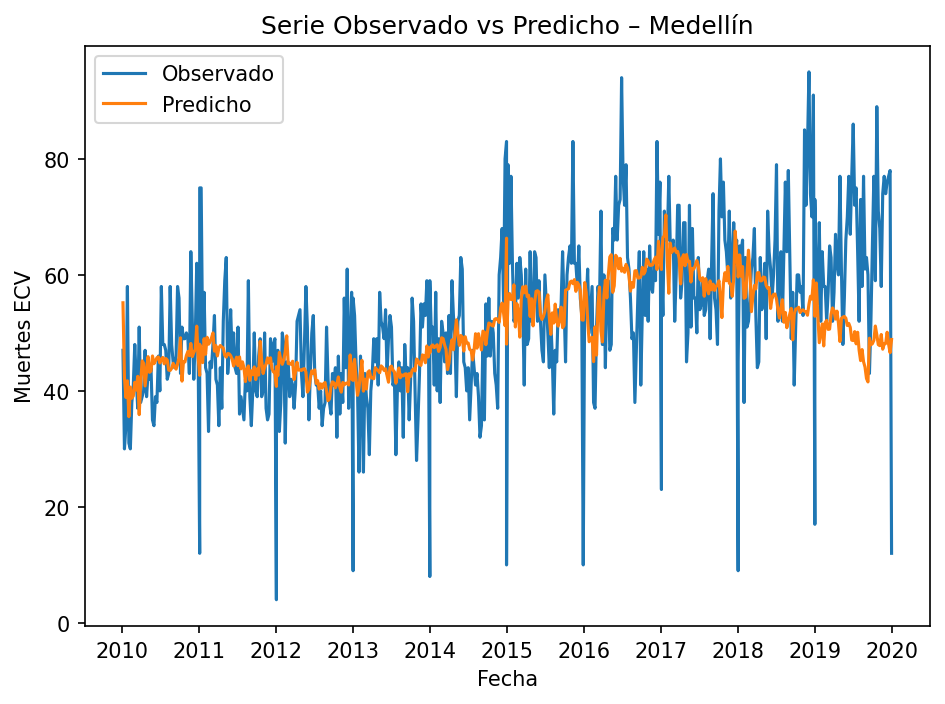

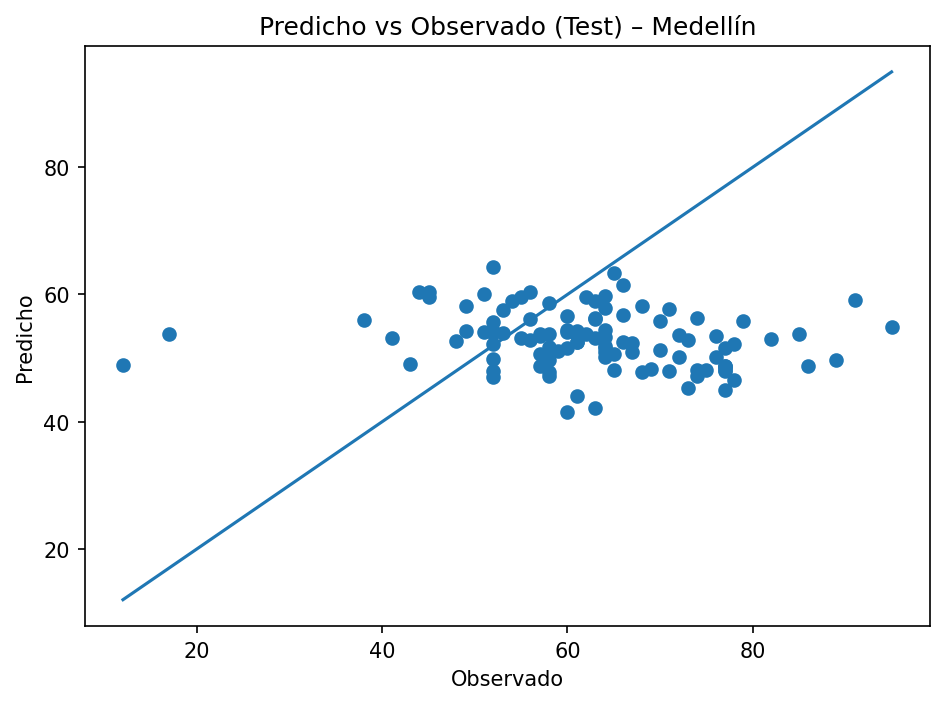

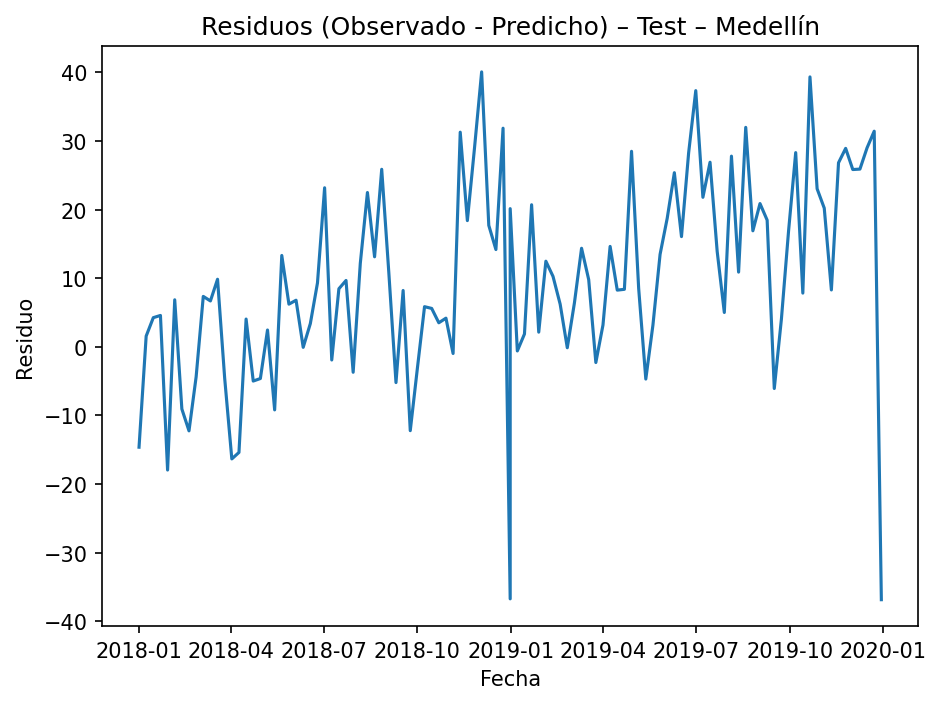

In [14]:

for ciudad, obj in pred_store.items():
    df_plot = pd.concat([obj["train"].assign(split="train"), obj["test"].assign(split="test")], ignore_index=True)
    plt.figure()
    plt.plot(df_plot["fecha"], df_plot["obs"], label="Observado")
    plt.plot(df_plot["fecha"], df_plot["pred"], label="Predicho")
    plt.title(f"Serie Observado vs Predicho – {ciudad}")
    plt.xlabel("Fecha"); plt.ylabel("Muertes ECV"); plt.legend(); plt.tight_layout()
    plt.savefig(FIG_DIR / f"Backtest_Serie_{ciudad}.png", dpi=FIG_DPI, bbox_inches="tight"); plt.show()

    te = obj["test"]
    plt.figure()
    plt.scatter(te["obs"], te["pred"])
    lim = [min(te["obs"].min(), te["pred"].min()), max(te["obs"].max(), te["pred"].max())]
    plt.plot(lim, lim)
    plt.title(f"Predicho vs Observado (Test) – {ciudad}")
    plt.xlabel("Observado"); plt.ylabel("Predicho"); plt.tight_layout()
    plt.savefig(FIG_DIR / f"Backtest_Scatter_{ciudad}.png", dpi=FIG_DPI, bbox_inches="tight"); plt.show()

    plt.figure()
    plt.plot(te["fecha"], te["obs"] - te["pred"])
    plt.title(f"Residuos (Observado - Predicho) – Test – {ciudad}")
    plt.xlabel("Fecha"); plt.ylabel("Residuo"); plt.tight_layout()
    plt.savefig(FIG_DIR / f"Backtest_Residuos_{ciudad}.png", dpi=FIG_DPI, bbox_inches="tight"); plt.show()


### 8.6 Bandas de confianza de la media

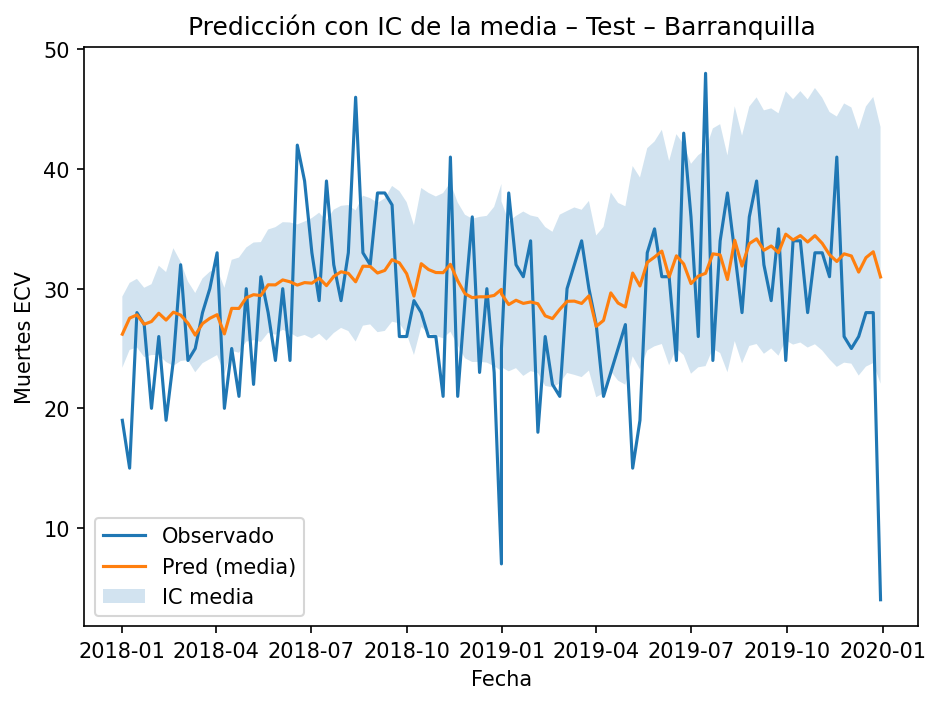

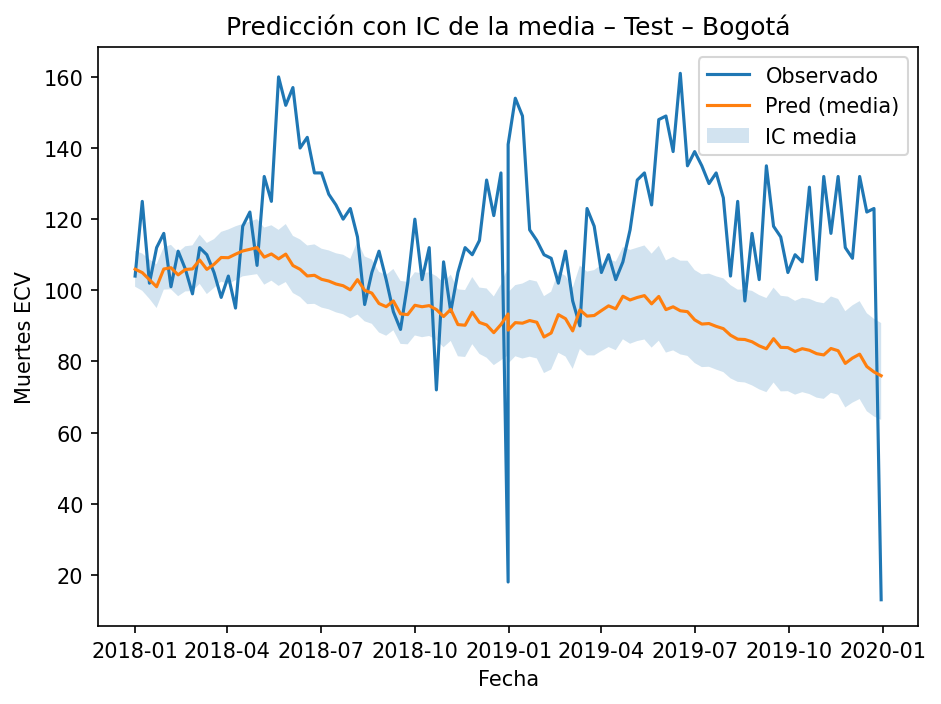

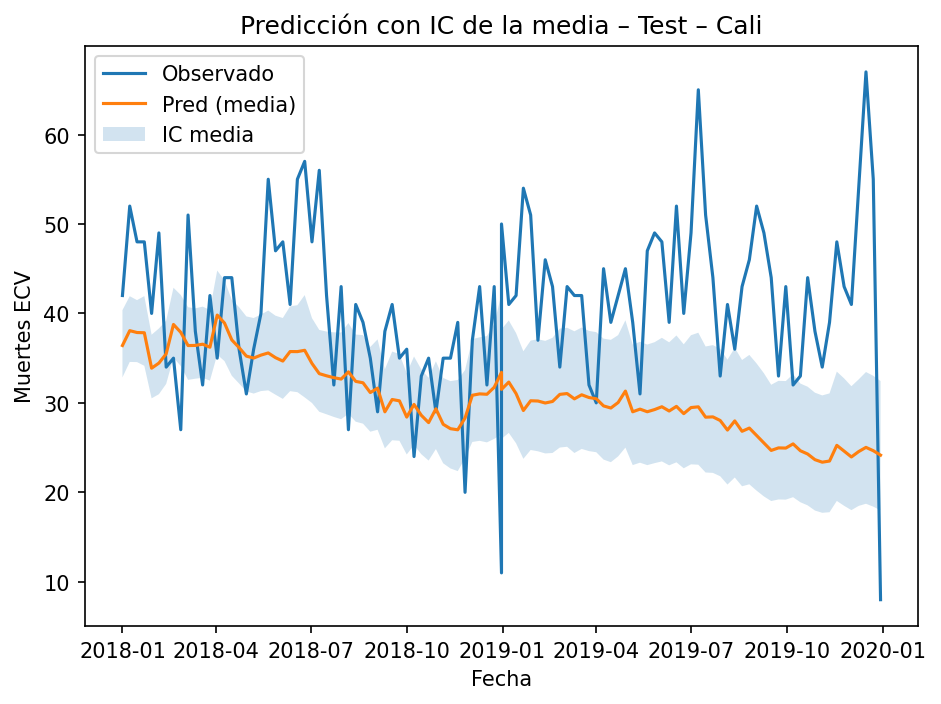

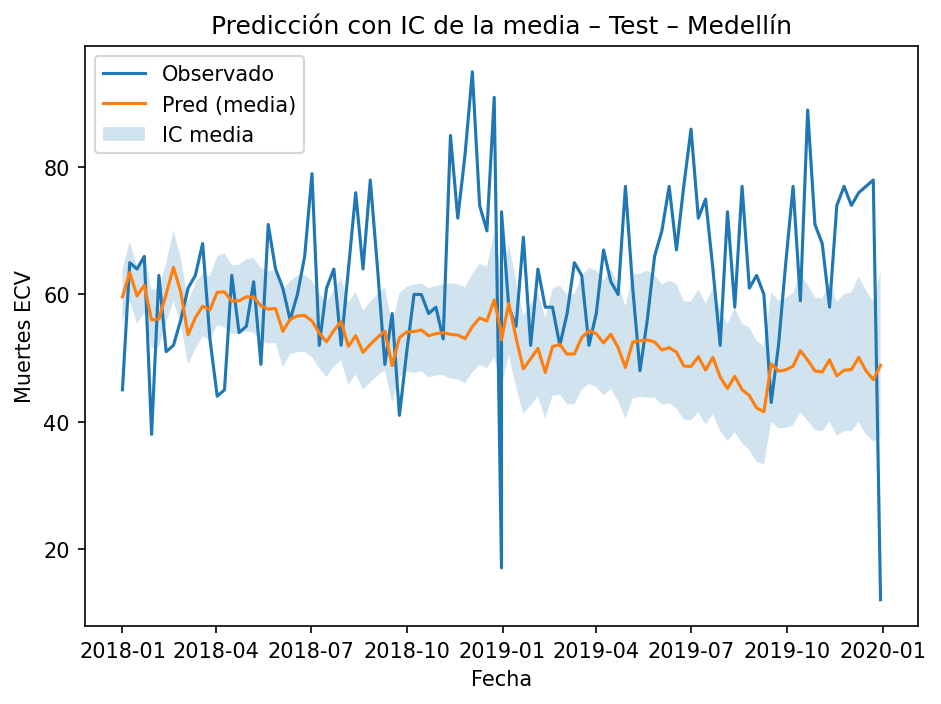

In [15]:

def mean_ci_glm(res, X, alpha=0.05):
    lp = np.asarray(X @ res.params)
    cov = res.cov_params()
    se = np.sqrt(np.sum((X @ cov) * X, axis=1))
    z = st.norm.ppf(1 - alpha/2.0)
    lp_lo, lp_hi = lp - z*se, lp + z*se
    mu    = res.family.link.inverse(lp)
    mu_lo = res.family.link.inverse(lp_lo)
    mu_hi = res.family.link.inverse(lp_hi)
    return mu, mu_lo, mu_hi

for ciudad, obj in pred_store.items():
    ft = obj["fit"]; origin = obj["origin"]
    test = obj["test"].copy()
    test_p = design_mats[ciudad]["test_p"].copy()
    Xte = design_mats[ciudad]["Xte"]
    mu, mu_lo, mu_hi = mean_ci_glm(ft["model"], Xte)
    out = test.copy(); out["mu_hat"] = mu; out["mu_lo"] = mu_lo; out["mu_hi"] = mu_hi
    plt.figure()
    plt.plot(out["fecha"], out["obs"], label="Observado")
    plt.plot(out["fecha"], out["mu_hat"], label="Pred (media)")
    plt.fill_between(out["fecha"].astype("datetime64[ns]"), out["mu_lo"], out["mu_hi"], alpha=0.2, label="IC media")
    plt.title(f"Predicción con IC de la media – Test – {ciudad}")
    plt.xlabel("Fecha"); plt.ylabel("Muertes ECV"); plt.legend(); plt.tight_layout()
    plt.savefig(FIG_DIR / f"Backtest_ICmedia_{ciudad}.png", dpi=FIG_DPI, bbox_inches="tight"); plt.show()
